In [18]:
%matplotlib notebook 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

In [19]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [20]:
numpy.random.seed(1234)

In [21]:
# data set generation
n_dim = 2

n_mean1 = numpy.array([-1., -1.])
n_cov1 = numpy.diag([0.5, .5])
n_mean2 = numpy.array([1., 1.])
n_cov2 = numpy.diag([0.5, .5])

p_mean1 = numpy.array([-1., 1.])
p_cov1 = numpy.diag([.5, .5])
p_mean2 = numpy.array([1., -1.])
p_cov2 = numpy.diag([.5, .5])

# generate postive examples
n_pos = 50
pos_y = numpy.ones(n_pos * 2) 
pos_x = numpy.concatenate([npr.randn(n_pos, n_dim) * numpy.diag(p_cov1)[None, :] + p_mean1[None,:],
                           npr.randn(n_pos, n_dim) * numpy.diag(p_cov2)[None, :] + p_mean2[None,:]])
n_pos *= 2
# generate negative examples
n_neg = 50
neg_y = -1 * numpy.ones(n_neg * 2) 
neg_x = numpy.concatenate([npr.randn(n_neg, n_dim) * numpy.diag(n_cov1)[None, :] + n_mean1[None,:],
                           npr.randn(n_neg, n_dim) * numpy.diag(n_cov2)[None, :] + n_mean2[None,:]])
n_neg *= 2
# combine them
y = numpy.concatenate([pos_y, neg_y])
x = numpy.concatenate([pos_x, neg_x], axis=0)
# shuffle them
si = npr.permutation(n_pos + n_neg)
y = y[si]
x = x[si]

# grab training examples
n_tra = numpy.round(0.5 * (n_pos + n_neg)).astype(numpy.int)

y_tra = y[:n_tra]
x_tra = x[:n_tra]

y_tes = y[n_tra:]
x_tes = x[n_tra:]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [22]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

In [23]:
def rbf(x, bases, width=1.):
    return numpy.exp(-(((x[:,None,:] - bases[None,:,:]) ** 2).sum(-1) / width))

In [24]:
def svm(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return numpy.sign(y)

In [25]:
def svm_dist(y, x, w, avg=False, pre=False):
    y_ = svm(x, w, pre=True)
    if pre:
        return 1. - y_ * y
    d = numpy.maximum(0., 1. - y_ * y)
    
    if not avg:
        return d
    return numpy.mean(d)

In [53]:
def cost(w, x, y, C=1.):
    return svm_dist(y, x, w, avg=True) + C * numpy.sum(w[:-1] ** 2)

svm_rule = grad(cost)

In [54]:
def _cost(w, x, y, C=1.):
    return cost(w, x, y, C), svm_rule(w, x, y, C)

In [55]:
n_bases = len(x_tra)
# select random centroids
cids = npr.permutation(len(x_tra))[:n_bases]
centroids = x_tra[cids]
x_tra_ = rbf(x_tra, centroids, 1.)


In [56]:
w0 = 1e-4 * npr.randn(n_bases+1); w0[-1] = 0.
w = numpy.copy(w0)

res = scipy.optimize.minimize(_cost, w0, (x_tra_, y_tra, True), 
                              method='L-BFGS-B', jac=True)

In [57]:
print res
w = res.x

      fun: 0.70409559346851258
 hess_inv: <101x101 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.16442681e-04,   5.07883322e-03,   3.41773516e-03,
        -5.85160325e-04,  -2.16089102e-04,   4.77291623e-03,
         6.28270842e-03,   4.58439351e-03,  -1.04672242e-04,
         2.74995155e-03,  -1.13527840e-03,  -2.61016732e-03,
        -4.80570667e-03,  -4.21779675e-04,  -1.18041171e-03,
        -6.06435538e-03,  -1.32683599e-04,   6.00525987e-04,
        -7.75636097e-03,  -7.65307183e-04,   5.93678477e-03,
        -6.80534895e-03,  -5.29456134e-05,  -1.36477862e-04,
        -5.43920652e-03,   6.37827850e-03,  -2.15414835e-04,
         1.28244025e-03,   5.57237210e-03,   6.26584081e-03,
        -7.09668311e-03,  -1.10441994e-04,   5.36984130e-03,
        -3.67880931e-04,  -5.16744325e-03,   3.33491994e-03,
         1.68481907e-05,  -4.45400301e-06,   4.95564250e-03,
         6.76369145e-04,   3.72826467e-03,  -1.76201712e-04,
        -3.81110247e-03,  -1.23186808e-04,  

In [58]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == -1 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [59]:
def vis_decision_boundary(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    x_tra_ = rbf(numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1), centroids, 1.)
    
    pred = svm(x_tra_, w)
    plt1 = plot.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

In [62]:
def vis_sv(w):
    plot.hold('on')
    
    for dd, xx in zip(w, x_tra):
        if dd >= 0.:
            plot.plot(xx[0], xx[1], '*')
    
    plot.hold('off')

<IPython.core.display.Javascript object>


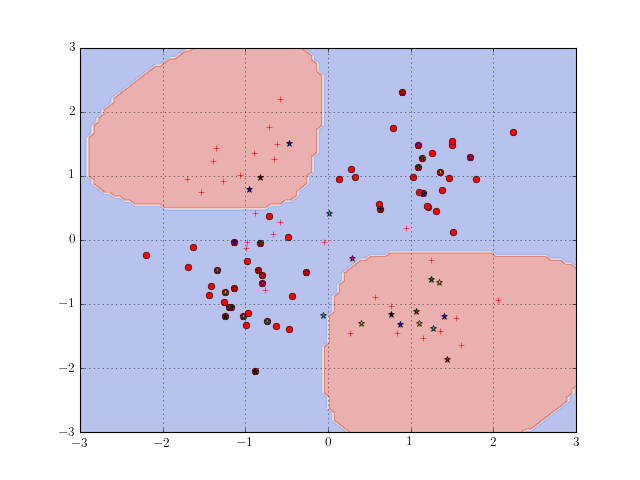

In [63]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
vis_sv(w)

plt1 = vis_decision_boundary(w, 'k--')

plot.show()

In [37]:
x_tra_ = rbf(x_tra, centroids, 1.)
x_tes_ = rbf(x_tes, centroids, 1.)

tra_er = numpy.sum(numpy.abs(svm(x_tra_, w) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(svm(x_tes_, w) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.22, Test error rate 0.16
